## 1 Gaussian process regression (20 points)
We learned in the lecture that Gaussian processes with a radial basis function kernel can interpolate or approximate functions whose values are known at arbitrary locations ("scattered data"). Here, we want to use this to reconstruct all missing pixels in the grayscale image cc_90.png (in https: //tinyurl.com/HD-EML-ex07-material-zip). The features $X_i$ are the pixel coordinates, and the response $y_i$ is the corresponding grayvalue. Pixels with grayvalue $=0$ are considered missing and shall be replaced with their regressed values. Since about $90 \%$ of the pixels are missing, not much is to be seen in cc_90.png.
We will use the generalized exponential kernel with hyper-parameters $\gamma \in(0,2]$ and $h$ :
$$
\begin{aligned}
K\left(\mathbf{x}, \mathbf{x}^{\prime} ; \gamma, h\right) & =\exp \left(-r\left(\mathbf{x}, \mathbf{x}^{\prime}, h\right)^\gamma\right) \\
r\left(\mathbf{x}, \mathbf{x}^{\prime} ; h\right) & =\sqrt{\frac{\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^2}{h^2}}
\end{aligned}
$$
Recall from the lecture that we collected the pairwise similarities between the given (training) points in a matrix $\mathbf{A}$ with elements
$$
\mathbf{A}_{i i^{\prime}}=K\left(\mathbf{x}_i, \mathbf{x}_{i^{\prime}} ; \gamma, h\right)
$$
The similarity of a test point $\widetilde{\mathbf{x}}$ with the training set is collected in the vector $\mathbf{b}$ with elements
$$
\mathbf{b}_i=K\left(\mathbf{x}_i, \widetilde{\mathbf{x}} ; \gamma, h\right)
$$
The mean of the predicted grayvalue $\hat{y}$ at location $\widetilde{\mathbf{x}}$ is calculated from the given grayvalues $\mathbf{y}$ as
$$
\hat{y}=\mathbf{b}^T \cdot\left(\mathbf{A}+\sigma^2 \cdot \mathbf{I}\right)^{-1} \cdot \mathbf{y}
$$
where $\sigma^2$ is the noise variance of the $\mathbf{y}$ and $\mathbf{I}$ the unit matrix. If you implement this formula naively, your program will probably be very slow. Use the following tricks to speed-up the execution:
- Cut off the kernel function at a sensibly large radius (i.e. set it to zero when the similarity gets reasonably small) to make A sparse, and use a sparse matrix class to store it (see ex. 4).

- Since $\mathbf{z}=\left(\mathbf{A}+\sigma^2 \cdot \mathbf{I}\right)^{-1} \cdot \mathbf{y}$ is the same for each test point, it should be pre-computed. However, computing this directly with the matrix inverse is much more expensive than solving the linear system
$$
\left(\mathbf{A}+\sigma^2 \cdot \mathbf{I}\right) \cdot \mathbf{z}=\mathbf{y}
$$
The difference is especially large for sparse matrices, and you could solve the equation with the function scipy.sparse.linalg.spsolve. However, an even bigger speed-up can be achieved by noticing that matrix $\mathbf{A}$ is actually banded (it has $\approx 2000$ non-zero diagonals). To exploit this, construct the matrix with coo_matrix.diagonal and solve the linear system with scipy.linalg. solve_banded.
- Avoid loops and use vectorization when possible.
Play with the hyper-parameters $\gamma, h, \sigma$ of the model to optimize the quality of the reconstructed mage.

A simpler approximation to Gaussian process regression can be achieved by Nadaraya-Watson regression. It avoides the expensive matrix inversion by defining the regression of a test point as:
$$
\hat{y}=\frac{\mathbf{b}^T \cdot \mathbf{y}}{\|\mathbf{b}\|_1}
$$
Implement this approach as well, and comment on the speed and quality of the two methods.

/var/folders/w9/ksgfnxyn4jg66j5nhtx4v0mc0000gn/T/ipykernel_2787/4115854978.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('/Users/anureddy/Desktop/SEM02/Essential_ML/Assignment07/EML_ex07_material/cc_90.png')


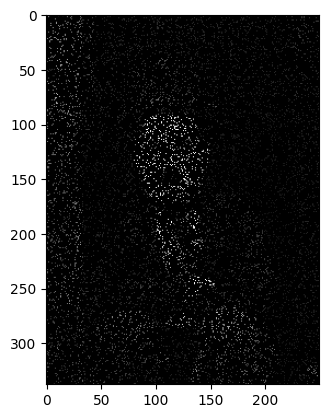

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.linalg
import imageio

# Load your image
image = imageio.imread('Assignment07/EML_ex07_material/cc_90.png')

# Define the kernel
def kernel(xi, xj, gamma, h):
    r = np.sqrt(((xi - xj)**2).sum(-1)) / h
    return np.exp(-r**gamma)

# Hyperparameters
gamma = 1.5  # You'll need to play with this
h = 0.1  # You'll need to play with this
sigma = 0.1  # You'll need to play with this

# Identify missing pixels (assumed to be zeros)
missing_pixels = image == 0

# Create training and test sets
train_X = np.transpose(np.nonzero(~missing_pixels))
train_y = image[~missing_pixels]
test_X = np.transpose(np.nonzero(missing_pixels))

# Compute the pairwise kernel matrix A and the vector b
A = kernel(train_X[None, :], train_X[:, None], gamma, h)
b = kernel(train_X[None, :], test_X[:, None], gamma, h)

# Convert A to a sparse matrix
A = sp.csc_matrix(A)

# Calculate z
z = scipy.sparse.linalg.spsolve(A + sigma**2 * sp.eye(A.shape[0]), train_y)

# Initialize an array to hold the predicted pixels
predicted_pixels = np.zeros(test_X.shape[0])

# Calculate the predicted value for each missing pixel
for i, x in enumerate(test_X):
    # Calculate the kernel similarity of the test point with each training point
    b = kernel(train_X, x, gamma, h)
    
    # Predict the pixel value
    predicted_pixels[i] = b @ z

# Replace the missing pixels in the image with the predicted pixels
reconstructed_image = image.copy()
reconstructed_image[missing_pixels] = predicted_pixels

# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.show()



Nadaraya-Watson regression:

Nadaraya-Watson regression is a simpler alternative to Gaussian process regression that avoids the expensive matrix inversion.


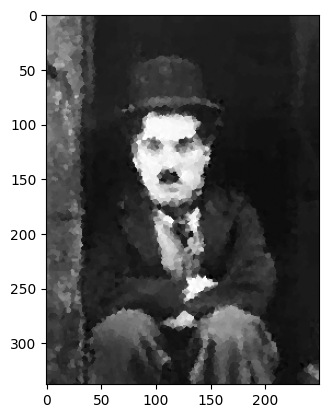

In [26]:
# Initialize an array to hold the predicted pixels
predicted_pixels_nw = np.zeros(test_X.shape[0])

# Calculate the predicted value for each missing pixel
for i, x in enumerate(test_X):
    # Calculate the kernel similarity of the test point with each training point
    b = kernel(train_X, x, gamma, h)
    
    # Predict the pixel value using Nadaraya-Watson regression
    predicted_pixels_nw[i] = (b @ train_y) / np.sum(b)

# Replace the missing pixels in the image with the predicted pixels
reconstructed_image_nw = image.copy()
reconstructed_image_nw[missing_pixels] = predicted_pixels_nw

# Display the reconstructed image
plt.imshow(reconstructed_image_nw, cmap='gray')
plt.show()



<div style="color: green;">
1. The sample's code uses sparse matrices for calculations, which is more memory-efficient and possibly faster for large datasets. The above code, on the other hand, uses dense matrices which can be more computationally intensive and memory-consuming for large datasets.<br>
2.It is worth noting that code optimization does not always have to be the primary focus, especially in the learning phase. Understanding the core concepts and logic behind the solution should be the main priority.<br>
3.For complex calculations like these, it can be beneficial to include print statements or use a debugger to inspect the shapes and values of matrices and arrays at different stages of the code. This can help identify any errors or unexpected results.
</div>

# 2 Fitting Circles

In this exercise we will have a closer look at fitting circles to data. The numpy-file circles.npy (in

https://tinyurl.com/HD-EML-ex07-material-zip) contains many pairs of x-y -coordinates, and can be loaded through data = np.load("circles.npy"). Visualize the data in a scatter plot to

show that the points are arranged in the shape of several circles and circle segments. Pay attention that the axes are scaled identically when plotting the data, otherwise your circles will look like ellipses. How many circles or circle segments would you fit into the data as a human? 6

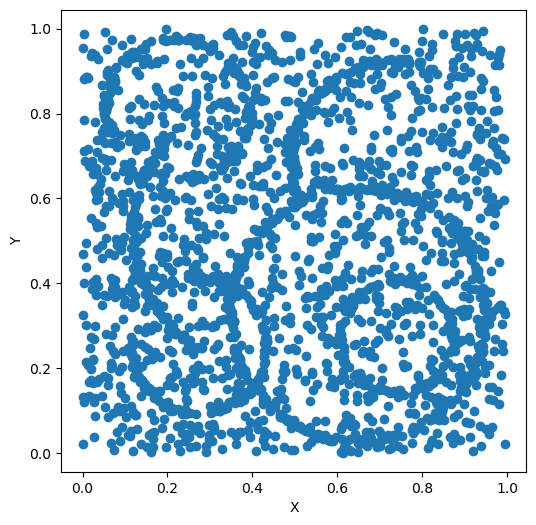

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = np.load("circles.npy")

# Separate x and y coordinates for clarity
x = data[:, 0]
y = data[:, 1]

# Create a scatter plot
plt.figure(figsize=(6,6))  # to ensure the plot is square, so the aspect ratio is 1:1
plt.scatter(x, y)

# Scale axes identically
plt.axis('equal')  # this ensures that the plot scales are equal, and thus circles won't look like ellipses

# Add labels (optional)
plt.xlabel("X")
plt.ylabel("Y")

# Display the plot
plt.show()



How many circles or circle segments would you fit into the data as a human? 6

# 2.1 RANSAC (8 Points)

Since the points of each circle are outliers to all other circles, we need a robust regression algorithm to fit the circles. To this end, implement the RANSAC algorithm and specialize it for the fitting of circles:

• For a set number of times T , repeat the following:

• Randomly choose 3 points and determine their circumcircle, parametrized by its radius and the coordinates of the center. Derive or look-up the formula for the circumcircle, given three points.

• Classify points as inliers whose Euclidean distance to this circle is less than ϵ (y hyperparameter). Count the inliers.

• If the inlier count for this circle is higher than for the best circle so far, save the current circle and its inliers as the new best.

• Fit further circles by deleting all inliers of the last fitted circle from the dataset and repeat the procedure.

Estimate the number of iterations T that is needed, as described in the lecture, using a rough guess of the inlier fraction for a single circle.
Plot all fitted circles on top of the original data and comment on the result. Implement experiments to find out how sensitive the result is to the choice of ϵ (the threshold for the inlier distance) and use a good value for the final run.

Hint: For plotting circles, you can use the following methods:

circle = plt.Circle ((cx , cy), radius=r, fill=False) # Create a circle
plt.gca().add_patch(circle) # Add it to the plot


In the next two sub-tasks, we will further improve the fits of the circles using two different methods. If you were unable to implement RANSAC, then either try to fit a circle manually to the data and get the inliers this way, or create data for a circle + noise and use it for the rest of the exercise.

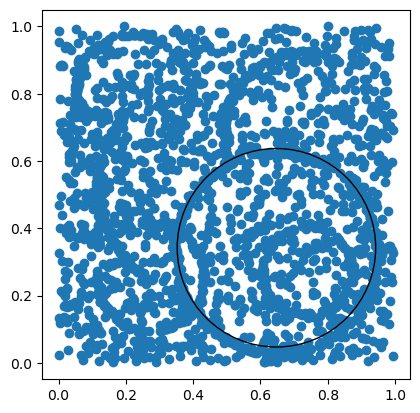

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# Define a function to calculate the circumcircle
def circumcircle(p1, p2, p3):
    ax, ay = p1
    bx, by = p2
    cx, cy = p3

    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))

    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    r = np.sqrt((ax - ux) ** 2 + (ay - uy) ** 2)

    return ux, uy, r

# RANSAC Algorithm
def ransac_circle_fitting(data, iterations, threshold):
    best_circle = None
    best_inliers = None
    best_inlier_count = 0

    for _ in range(iterations):
        # Randomly choose 3 points
        sample = data[np.random.choice(data.shape[0], size=3, replace=False), :]

        # Determine the circumcircle
        circle = circumcircle(sample[0], sample[1], sample[2])
        cx, cy, r = circle

        # Classify points as inliers or outliers
        distances = np.sqrt((data[:, 0] - cx)**2 + (data[:, 1] - cy)**2)
        inliers = data[np.where(abs(distances - r) <= threshold)]
        inlier_count = len(inliers)

        # Check if this circle is better than the previous best
        if inlier_count > best_inlier_count:
            best_circle = circle
            best_inliers = inliers
            best_inlier_count = inlier_count

    return best_circle, best_inliers


# Parameters for RANSAC
iterations = 1000  # This could be adjusted based on the inlier fraction estimation
threshold = 0.01  # This is epsilon, the threshold for the inlier distance

# Apply RANSAC and get the best circle
circle, inliers = ransac_circle_fitting(data, iterations, threshold)

# Visualize the result
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1])
circle = plt.Circle((circle[0], circle[1]), circle[2], fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()


<div style="color: green;">
1. The sample's code includes an option to find multiple circles by removing inliers of the previously found circle and repeating the process. Whereas on the above's code, which can only find one circle.<br>
2.the sample code   used a colormap for plotting multiple circles, and adjusted the number of iterations and epsilon values in a structured manner. The sample code  conducted an experiment to find out the sensitivity of the result to the choice of epsilon and found a good value for the final run. This is a better approach than the above code, which simply used fixed values without experimentation.

</div>

## 2.2

In [5]:
print(circle)

Circle(xy=(0.647452, 0.342194), radius=0.294942)


In [6]:
import numpy as np
from scipy.optimize import least_squares

def circle_residuals(params, data):
    xc,yc,r = params
    x = data[:,0]
    y = data[:,1]
    
    return np.sqrt((x-xc)**2 + (y-yc)**2) - r

def fit_circles(data, initial_params):
    def objective_function(params):
        return circle_residuals(params, data)
    result = least_squares(objective_function, initial_params, method='lm')
    xc,yc,r = result.x
    return xc,yc,r

initial_params = np.array([0.647894, 0.320672, 0.299284])
xc,yc,r = fit_circles(inliers, initial_params)
print("center", xc, yc)
print("radius",r)

center 0.6469487282058257 0.3379488322059307
radius 0.2958143640416911


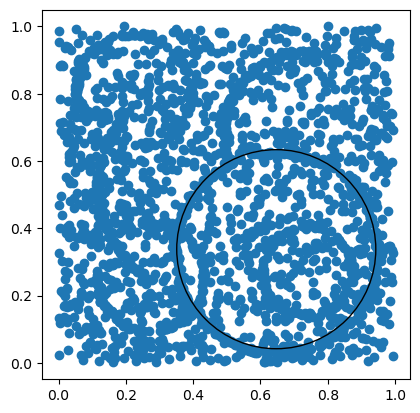

In [7]:
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1])
circle = plt.Circle((xc, yc), r, fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

<div style="color: green;">
1. The above code   doesn't include any mechanism for refining the fit based on inliers and outliers or iterative optimization, which might result in less accurate fits on noisy data.
</div>

## 2.3
The relationship between $\beta_{1}, \beta_{2}, \beta_{3} $ are derived from the equation of the circle. The general equation of the circle is
${(x - h)}^{2}\  + {(y - k)}^{2}\  = \ r^{2}$

If we expand and compare it with least square problem we get:

$x^{2} - \ 2hx\  + \ y^{3} - 2ky + h^{2} + k^{2} - r^{2}\  = \ 0$

comparing with $\beta_{1}X + \beta_{2}X + \beta_{3} = x^{2}+y^{2}$, we can derive that:

$- 2h\  = \ \beta_{1}\  = > \ h\  = \  - \beta_{1}/2$

$- 2k\  = \ \beta_{2}\  = > \ h\  = \  - \beta_{2}/2$

$h^{2} + k^{2} - r^{2}\  = \ \beta_{3}\  = > \ r\  = \ \sqrt{}h^{2} + k^{2} - \beta_{3}$



In [8]:
import numpy as np
from scipy.linalg import lstsq

def fit_circles(data):
    Xi = inliers[:,0] **2
    Yi = 2*inliers[:, 0]
    Wi = inliers[:,0]**2 + inliers[:,1]**2
    X = np.column_stack((Xi, Yi, np.ones_like(Xi)))
    P, _, _, _ = lstsq(X, Wi)
    A, B, D = P
    xc = - B / (2*(A-1))
    yc = 0 if A-1 != 0 else -B / (2 * (A - 1))
    r = np.sqrt((-D + yc**2) / (A-1))
    return xc,yc,r

initial_params = np.array([0.647894, 0.320672, 0.299284])
xc,yc,r = fit_circles(inliers)
print("center", xc, yc)
print("radius",r)

center 0.32556320424131885 0
radius nan


C:\Users\Keerthan\AppData\Local\Temp\ipykernel_17864\2004727602.py:13: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt((-D + yc**2) / (A-1))


<div style="color: green;">
1. Implementation:

The sample's code is more complete and thorough, showing the process of fitting circles using algebraic distance with the use of RANSAC for outlier removal. It also includes a procedure for visualizing the data and the fitted circles, as well as experimenting with different values of the inlier threshold.

On the other hand, the above's code is more succinct and lacks some parts. It doesn't show how the input data is prepared and how the inliers are selected. It seems to assume that the inliers variable has been defined elsewhere in the code. This makes it harder to follow and understand the logic of the above's code.<br>
2.Visualizations and experiments:

The sample's code includes a plot of the resulting circles and an investigation of the influence of the inlier threshold, providing insights into the effects of the parameters on the circle fitting.

The above's code does not include any visualizations or experiments. Including these would make it easier to evaluate the effectiveness of the circle fitting and to understand how the parameters affect the results.
</div>